In [2]:
!pip install pandas_ta
!pip install neuralfit
!pip install neat-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=bfc6dbf8888c230245be59dc2054c4c28eb0ce914f2a24a4d69783d222be2d66
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 4.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import neuralfit
import neat
import os
import os.path

In [5]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [6]:
df = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


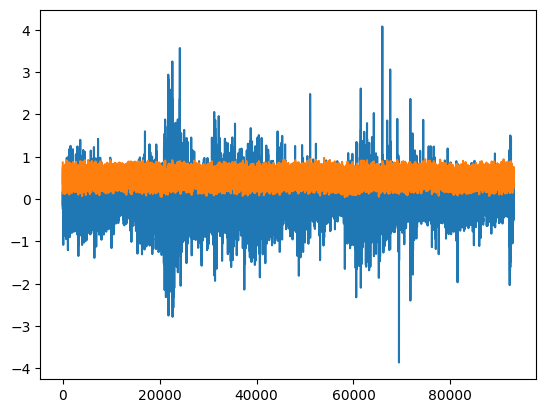

In [8]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [9]:
Model = neuralfit.Model(2, 1)
Model.compile(optimizer='alpha', loss="mae")

In [70]:

def run_env_loop(net):
  profit = 0
  for count in range(10,100):
    action = net.activate(INDICATORS[count])
    profit += change[count] if action[0]>.5 else 0
  return profit


def train_func(genomes):

  #init variables
  losses = np.zeros(len(genomes))

  for i in range(len(genomes)):

    losses[i] = run_env_loop(genomes[i])



  return losses

In [71]:
def eval_genomes(genomes, config):
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = -run_env_loop(net)


In [72]:
!git clone https://github.com/CodeReclaimers/neat-python

fatal: destination path 'neat-python' already exists and is not an empty directory.


In [80]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     '/content/neat-python/examples/xor/config-feedforward')

In [81]:
p = neat.Population(config)

In [82]:
p.add_reporter(neat.StdOutReporter(False))

In [ ]:
winner = p.run(eval_genomes)

Streaming output truncated to the last 5000 lines.
Population's average fitness: 6.29966 stdev: 6.54716
Best fitness: 18.07673 - size: (6, 7) - species 1 - id 12587
Average adjusted fitness: 0.486
Mean genetic distance 2.601, standard deviation 0.750
Population of 151 members in 5 species
Total extinctions: 0
Generation time: 0.100 sec (0.100 average)

 ****** Running generation 179 ****** 

Population's average fitness: 5.75533 stdev: 6.47236
Best fitness: 18.07673 - size: (6, 7) - species 1 - id 12587
Average adjusted fitness: 0.471
Mean genetic distance 2.608, standard deviation 0.792
Population of 151 members in 5 species
Total extinctions: 0
Generation time: 0.122 sec (0.101 average)

 ****** Running generation 180 ****** 

Population's average fitness: 5.59980 stdev: 6.52903
Best fitness: 18.07673 - size: (6, 7) - species 1 - id 12587
Average adjusted fitness: 0.517
Mean genetic distance 2.618, standard deviation 0.788
Population of 151 members in 5 species
Total extinctions: 0
G

In [ ]:
Model.func_evolve(train_func, pop_size=100, epochs=1000,verbose=1)